### Подключение библиотек и скриптов

In [1]:
from IPython.core.display import display, HTML
display(HTML('<style>.container { width:72.5% !important; }</style>'))

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
plt.rcParams.update({'font.size': 14})
pd.set_option('precision', 3)
pd.set_option('max_columns', 100)
pd.set_option('display.float_format', lambda x: '%.5f' % x)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
pd.set_option('max_colwidth', 300)

### Пути к директориям и файлам

In [5]:
# from google.colab import files
# uploaded = files.upload()

In [6]:
TRAIN_DATASET_PATH = 'data/train.csv'
TEST_DATASET_PATH = 'data/test.csv'
RES_PATH = 'data/result_submission.csv'

### Загрузка данных

In [7]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)

### Feature engineering / Работа с признаками

In [8]:
def feature_engineering(df):
    # Построение новых признаков
    df['high_rate'] = (df['qualification'] >= 2.5) & (df['lesson_price'] >= 2500) & (df['years_of_experience'] >= 5).astype('bool')
    df['tutor_rating'] = 1
    df.loc[(df['qualification'] >= 3) & (df['lesson_price'] >= 3500), 'tutor_rating'] = 5
    df.loc[((df['qualification'] < 3) & (df['qualification'] >= 2)) & ((df['lesson_price'] < 3500) & (df['lesson_price'] >= 2500)), 'tutor_rating'] = 4
    df.loc[((df['qualification'] < 2) & (df['qualification'] >= 1)) & ((df['lesson_price'] < 2500) & (df['lesson_price'] >= 1500)), 'tutor_rating'] = 3
    df.loc[(df['qualification'] < 1) & (df['lesson_price'] < 1000), 'tutor_rating'] = 2
    df['q_lp_ratio'] =  df['qualification'] * df['lesson_price']

In [9]:
feature_engineering(train_df)
feature_engineering(test_df)

### Корреляция признаков

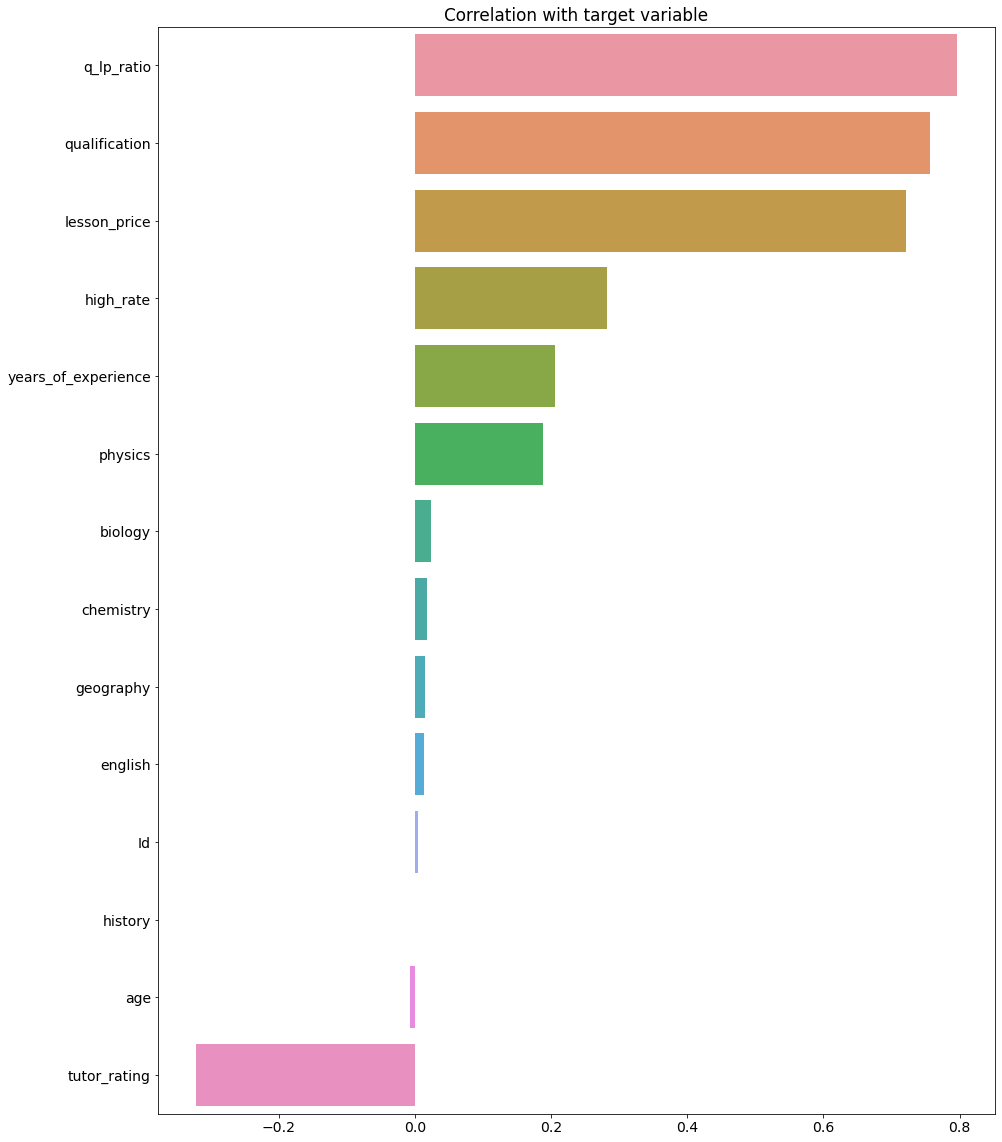

In [10]:
TARGET_NAME = 'mean_exam_points'

corr_with_target = train_df.corr()[TARGET_NAME].sort_values(ascending=False)[1:]

plt.figure(figsize=(15, 20))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

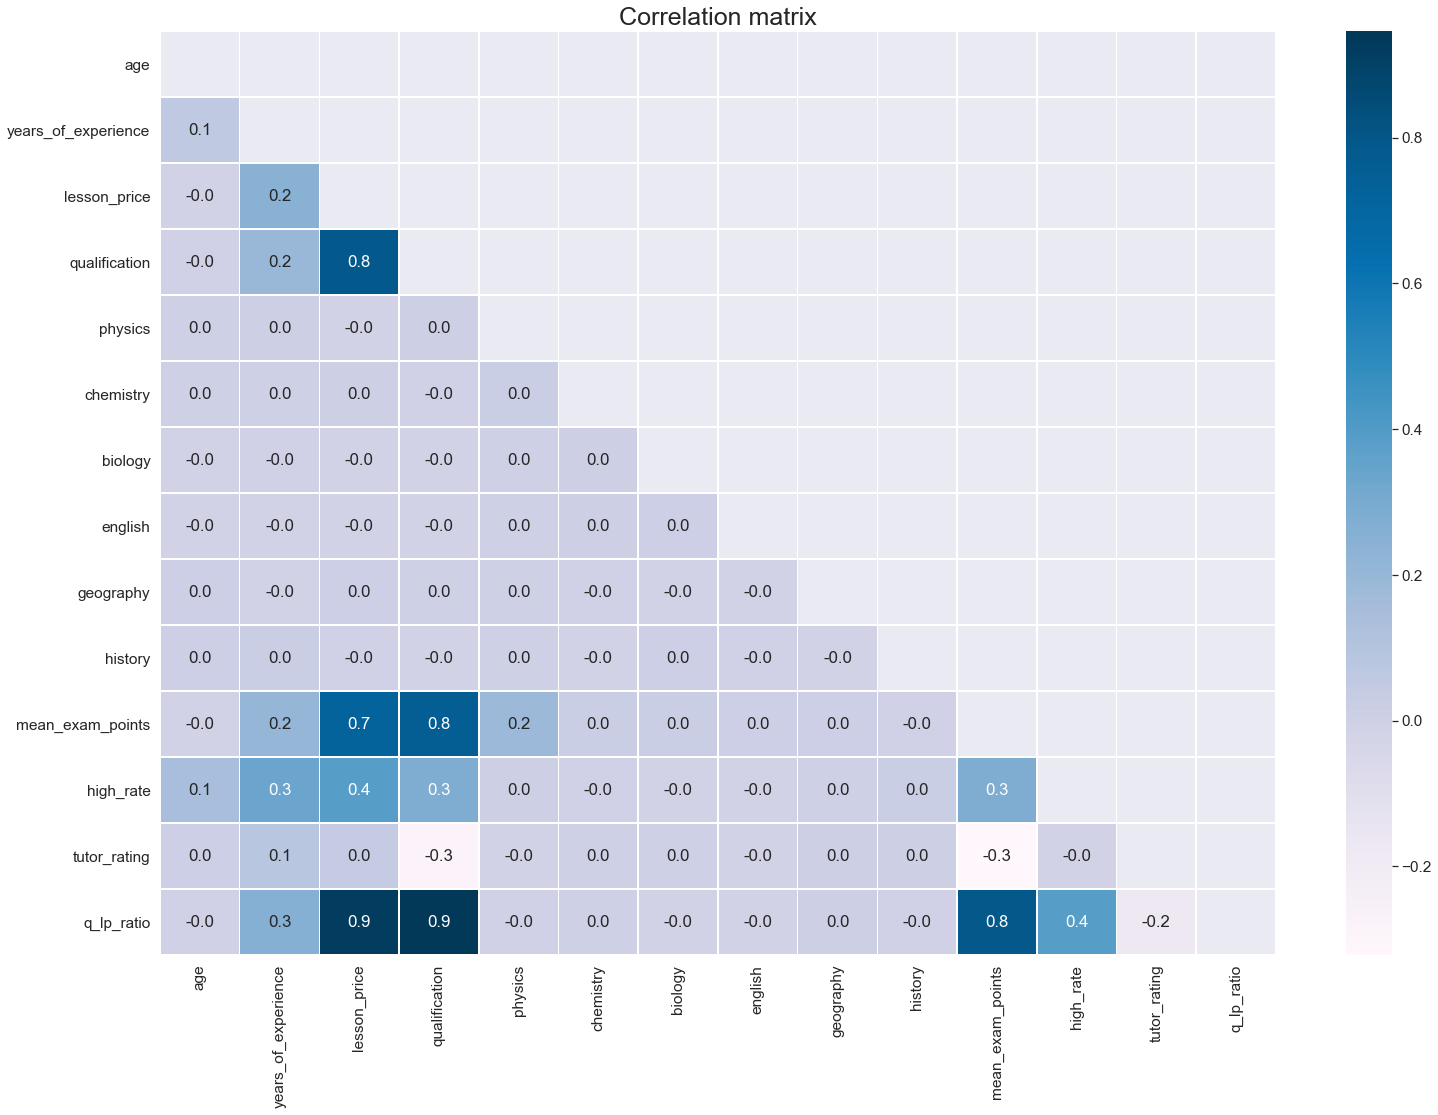

In [11]:
# Correlation Matrix
num_features = pd.DataFrame(train_df)
num_features.drop('Id', axis=1, inplace=True)

corr = num_features.corr()
plt.figure(figsize = (25, 17))
mask = np.zeros_like(corr, dtype=np.bool)  # отрезаем лишнюю половину матрицы
mask[np.triu_indices_from(mask)] = True
sns.set(font_scale=1.4)
sns.heatmap(num_features.corr(), mask=mask, annot=True, fmt='.1f', linewidths=.5, cmap='PuBu')
plt.title('Correlation matrix', fontsize=25)
plt.show()

### Создание класса модели - Gradient Boosting

In [12]:
# Реализуем класс узла
class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index                # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t                        # значение порога
        self.true_branch = true_branch    # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [13]:
# И класс терминального узла (листа)
class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
      
    
    def predict(self):    
        # Расчет среднего значения в листе
        prediction = np.mean(self.labels)
        return prediction 

In [14]:
# Реализуем класс дерева
class Tree:

    def __init__(self, max_depth):
        self.max_depth = max_depth
        self.tree = None


    # В случае регрессии разброс будет характеризоваться дисперсией
    def variance(self, labels):
        return np.var(labels)


    # Расчет качества
    def quality(self, left_labels, right_labels, current_variance):
        # Доля выбоки, которая переходит в левое поддерево
        p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
        
        return current_variance - p * self.variance(left_labels) - (1 - p) * self.variance(right_labels)

    
    # Разбиение датасета в узле
    def split(self, data, labels, index, t):
        left = np.where(data[:, index] <= t)
        right = np.where(data[:, index] > t)
            
        true_data = data[left]
        false_data = data[right]
        true_labels = labels[left]
        false_labels = labels[right]
            
        return true_data, false_data, true_labels, false_labels

    
    # Нахождение наилучшего разбиения
    def find_best_split(self, data, labels):     
        #  Обозначение минимального количества объектов в узле
        min_leaf = 5

        current_variance = self.variance(labels)

        best_quality = 0
        best_t = None
        best_index = None
        
        n_features = data.shape[1]
        
        for index in range(n_features):
            # Проверяем только уникальные значения признака, исключая повторения
            t_values = np.unique([row[index] for row in data])
            
            for t in t_values:
                true_data, false_data, true_labels, false_labels = self.split(data, labels, index, t)
                # Пропускаем разбиения, в которых в узле остается менее 5 объектов
                if len(true_data) < min_leaf or len(false_data) < min_leaf:
                    continue
                
                current_quality = self.quality(true_labels, false_labels, current_variance)
                
                # Выбираем порог, на котором получается максимальный прирост качества
                if current_quality > best_quality:
                    best_quality, best_t, best_index = current_quality, t, index

        return best_quality, best_t, best_index
    

    # Построение дерева с помощью рекурсивной функции
    def build_tree(self, data, labels, max_depth, depth=0):
        quality, t, index = self.find_best_split(data, labels)

        # Прекращаем рекурсию, когда нет прироста качества или достигнута
        # максимальная глубина дерева
        if quality == 0 or depth >= max_depth:
            return Leaf(data, labels)

        true_data, false_data, true_labels, false_labels = self.split(data, labels, index, t)

        # Рекурсивно строим два поддерева
        true_branch = self.build_tree(true_data, true_labels, max_depth, depth+1)
        false_branch = self.build_tree(false_data, false_labels, max_depth, depth+1)

        # Возвращаем класс узла со всеми поддеревьями, т.е. целого дерева
        return Node(index, t, true_branch, false_branch)
    

    def predict_target(self, obj, node):
        # Останавливаем рекурсию, если достигли листа
        if isinstance(node, Leaf):
            answer = node.prediction
            return answer

        if obj[node.index] <= node.t:
            return self.predict_target(obj, node.true_branch)
        else:
            return self.predict_target(obj, node.false_branch)
    

    def predict(self, data):
        values = []
        for obj in data:
            prediction = self.predict_target(obj, self.tree)
            values.append(prediction)
        return values
    

    # Строим дерево
    def fit(self, data, labels):
        self.tree = self.build_tree(data, labels, self.max_depth)
        return self

In [15]:
# Реализуем класс для градиентного бустинга
class GB:
    
    def __init__(self, n_trees, max_depth, coefs, eta):
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.coefs = coefs
        self.eta = eta
        self.trees = []


    def bias(self, y, z):
        return (y - z)
    

    def fit(self, X_train, y_train):  
        # Деревья будем записывать в список
        trees = []

        for i in range(self.n_trees):
            tree = Tree(max_depth=self.max_depth)         

            # Инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
            # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
            if len(self.trees) == 0:
                # Обучаем первое дерево на обучающей выборке
                tree.fit(X_train, y_train)
            else:
                # Получение ответов на текущей композиции
                target = self.predict(X_train)
                
                # Алгоритмы начиная со второго обучаем на сдвиг
                tree.fit(X_train, self.bias(y_train, target))
            self.trees.append(tree)
            
        return self
    
    
    def predict(self, X):
        # Реализуемый алгоритм градиентного бустинга будет инициализироваться нулевыми значениями,
        # поэтому все деревья из списка trees_list уже являются дополнительными и при предсказании прибавляются с шагом eta
        return np.array([sum([self.eta * coef * alg.predict([x])[0] for alg, coef in zip(self.trees, self.coefs)]) for x in X])

In [16]:
# Функция вычисления метрики R2
def R2(y_pred, y_true):
    numerator = ((y_true - y_pred) ** 2).sum(axis=0, dtype=np.float64)
    denominator = ((y_true - np.average(y_true)) ** 2).sum(axis=0, dtype=np.float64)
    return 1 - (numerator / denominator)

### Обучение модели

In [17]:
features = ['age', 'years_of_experience', 'lesson_price', 'qualification', 'physics', 'chemistry', 'biology', 'english', 'geography', 'history', 'tutor_rating']

In [18]:
X = train_df[features].values
y = train_df[TARGET_NAME].values

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 54)

In [20]:
# Число деревьев в ансамбле
n_trees = 17

# Коэффициент
coefs = [1] * n_trees

# Максимальная глубина деревьев
max_depth = 5

# Шаг
eta = 0.41

In [21]:
# Обучение модели
gb = GB(n_trees, max_depth, coefs, eta)
gb.fit(X_train, y_train)

### Прогнозирование и сохранение результатов

In [22]:
# Предскажем значения на тестовом наборе
y_pred_test = gb.predict(X_test)

In [23]:
R2(y_pred_test, y_test)

0.7834894976902051

In [24]:
gb_final = GB(n_trees, max_depth, coefs, eta)
gb_final.fit(X, y)

In [25]:
X_test = test_df[features].values

In [26]:
y_pred_test = gb_final.predict(X_test)

In [27]:
submissions = pd.concat([test_df['Id'], pd.Series(y_pred_test)], axis=1)
submissions = submissions.rename(columns={0: 'mean_exam_points'})

submissions.to_csv(RES_PATH, index=False, encoding='utf-8')

In [28]:
# from google.colab import files
# files.download('./result_submission.csv')